# ML Engagment Demo
Using a little machine learning, can we tell this difference between and engaged-unengaged task?

Description:
In this second exercise, we will learn how to use an automatic algorithm to
recognize somebody's mental states from their EEG. We will use a classifier,
i.e., an algorithm that, provided some data, learns to recognize patterns,
and can then classify similar unseen information.

## Setup:

In [1]:
import numpy as np  # Module that simplifies computations on matrices
import matplotlib.pyplot as plt  # Module used for plotting
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data



import bci_workshop_tools as BCIw  # Our own functions for the workshop
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
%matplotlib tk
print('Setup Complete.')

Setup Complete.


## Data collection and analysis
We will show the computer 30 seconds of "neutral" cognitive data, followed by 30 second of "engaged" data. The computer will then try and match new data to it's learned data. It should be able to tell a binary difference between the two states.
![alt text](rt_ML_figure2.png "Engagement Decision Plot")

Looking for an EEG stream...
Im ready
IM ready
IM READY

 Stimuli 



C:\Users\tdgri\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


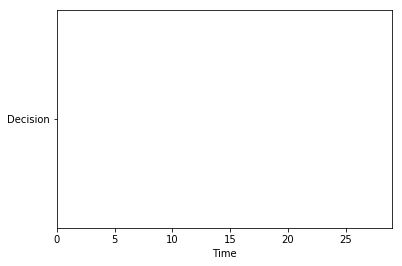

Press Ctrl-C in the console to break the while loop.
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
Closed!


In [3]:
if __name__ == "__main__":

    """ 1. CONNECT TO EEG STREAM """

    # Search for active LSL stream
    print('Looking for an EEG stream...')
    streams = resolve_byprop('type', 'EEG', timeout=2)
    if len(streams) == 0:
        raise RuntimeError('Can\'t find EEG stream.')

    # Set active EEG stream to inlet and apply time correction
    print("Im ready")
    print("IM ready")
    print("IM READY")
    inlet = StreamInlet(streams[0], max_chunklen=12)
    eeg_time_correction = inlet.time_correction()

    # Get the stream info, description, sampling frequency, number of channels
    info = inlet.info()
    description = info.desc()
    fs = int(info.nominal_srate())
    n_channels = info.channel_count()

    # Get names of all channels
    ch = description.child('channels').first_child()
    ch_names = [ch.child_value('label')]
    for i in range(1, n_channels):
        ch = ch.next_sibling()
        ch_names.append(ch.child_value('label'))

    """ 2. SET EXPERIMENTAL PARAMETERS """

    # Length of the EEG data buffer (in seconds)
    # This buffer will hold last n seconds of data and be used for calculations
    buffer_length = 15

    # Length of the epochs used to compute the FFT (in seconds)
    epoch_length = 1

    # Amount of overlap between two consecutive epochs (in seconds)
    overlap_length = 0.8

    # Amount to 'shift' the start of each next consecutive epoch
    shift_length = epoch_length - overlap_length

    # Index of the channel (electrode) to be used
    # 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
    index_channel = [0, 1, 2, 3]
    # Name of our channel for plotting purposes
    ch_names = [ch_names[i] for i in index_channel]
    n_channels = len(index_channel)

    # Get names of features
    # ex. ['delta - CH1', 'pwr-theta - CH1', 'pwr-alpha - CH1',...]
    feature_names = BCIw.get_feature_names(ch_names)

    # Number of seconds to collect training data for (one class)
    training_length = 30

    """ 3. RECORD TRAINING DATA """

    # Record data for mental activity 0
    #winsound.Beep(400,1000)
    eeg_data0, timestamps0 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data0 = np.array(eeg_data0)[:, index_channel]

    print('\n Stimuli \n')

    # Record data for mental activity 1
    winsound.Beep(400,1000) # Beep sound
    eeg_data1, timestamps1 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data1 = np.array(eeg_data1)[:, index_channel]

    # Divide data into epochs
    eeg_epochs0 = BCIw.epoch(eeg_data0, epoch_length * fs,
                             overlap_length * fs)
    eeg_epochs1 = BCIw.epoch(eeg_data1, epoch_length * fs,
                             overlap_length * fs)

    """ 4. COMPUTE FEATURES AND TRAIN CLASSIFIER """

    feat_matrix0 = BCIw.compute_feature_matrix(eeg_epochs0, fs)
    feat_matrix1 = BCIw.compute_feature_matrix(eeg_epochs1, fs)

    [classifier, mu_ft, std_ft] = BCIw.train_classifier(
            feat_matrix0, feat_matrix1, 'SVM')

    winsound.Beep(500,1000)

    """ 5. USE THE CLASSIFIER IN REAL-TIME"""

    # Initialize the buffers for storing raw EEG and decisions
    eeg_buffer = np.zeros((int(fs * buffer_length), n_channels))
    filter_state = None  # for use with the notch filter
    decision_buffer = np.zeros((30, 1))

    plotter_decision = BCIw.DataPlotter(30, ['Decision'])

    # The try/except structure allows to quit the while loop by aborting the
    # script with <Ctrl-C>
    print('Press Ctrl-C in the console to break the while loop.')

    try:
        while True:

            """ 3.1 ACQUIRE DATA """
            # Obtain EEG data from the LSL stream
            eeg_data, timestamp = inlet.pull_chunk(
                    timeout=1, max_samples=int(shift_length * fs))

            # Only keep the channel we're interested in
            ch_data = np.array(eeg_data)[:, index_channel]

            # Update EEG buffer
            eeg_buffer, filter_state = BCIw.update_buffer(
                    eeg_buffer, ch_data, notch=True,
                    filter_state=filter_state)

            """ 3.2 COMPUTE FEATURES AND CLASSIFY """
            # Get newest samples from the buffer
            data_epoch = BCIw.get_last_data(eeg_buffer,
                                            epoch_length * fs)

            # Compute features
            feat_vector = BCIw.compute_feature_vector(data_epoch, fs)
            y_hat = BCIw.test_classifier(classifier,
                                         feat_vector.reshape(1, -1), mu_ft,
                                         std_ft)
            print(y_hat)

            decision_buffer, _ = BCIw.update_buffer(decision_buffer,
                                                    np.reshape(y_hat, (-1, 1)))

            """ 3.3 VISUALIZE THE DECISIONS """
            plotter_decision.update_plot(decision_buffer)
            plt.pause(0.00001)

    except KeyboardInterrupt:

        print('Closed!')


In [4]:
            """ 3.1 ACQUIRE DATA """
            # Obtain EEG data from the LSL stream
            eeg_data, timestamp = inlet.pull_chunk(
                    timeout=1, max_samples=int(shift_length * fs))

            # Only keep the channel we're interested in
            ch_data = np.array(eeg_data)[:, index_channel]

            # Update EEG buffer
            eeg_buffer, filter_state = BCIw.update_buffer(
                    eeg_buffer, ch_data, notch=True,
                    filter_state=filter_state)

            """ 3.2 COMPUTE FEATURES AND CLASSIFY """
            # Get newest samples from the buffer
            data_epoch = BCIw.get_last_data(eeg_buffer,
                                            epoch_length * fs)

            # Compute features
            feat_vector = BCIw.compute_feature_vector(data_epoch, fs)
            y_hat = BCIw.test_classifier(classifier,
                                         feat_vector.reshape(1, -1), mu_ft,
                                         std_ft)
            print(y_hat)

            decision_buffer, _ = BCIw.update_buffer(decision_buffer,
                                                    np.reshape(y_hat, (-1, 1)))

            """ 3.3 VISUALIZE THE DECISIONS """
            plotter_decision.update_plot(decision_buffer)
            plt.pause(0.00001)

[1.]
